In [73]:
import pandas as pd

In [74]:
import numpy as np

In [75]:
# Reproducibility
rng = np.random.default_rng(42)


In [76]:
n = 10000
df = pd.DataFrame({
    "age": rng.integers(18, 70, size=n),
    "usage_gb": np.round(rng.normal(12, 6, size=n).clip(0, None), 1),
    "complaints": rng.integers(0, 6, size=n),
    "tenure_months": rng.integers(1, 60, size=n),
    "plan_type": rng.choice(["Prepaid", "Postpaid"], size=n, p=[0.6, 0.4])
})


In [77]:
# Simple churn signal (not perfect): high complaints + low tenure + low usage more likely to churn
logit = (
    -2.0
    + 0.35*df["complaints"]
    - 0.03*df["tenure_months"]
    - 0.04*df["usage_gb"]
    + (df["plan_type"] == "Prepaid").astype(int)*0.4
)
prob = 1/(1+np.exp(-logit))
df["churn"] = (rng.random(n) < prob).astype(int)


In [78]:
# Intentionally add a few missing/odd values to practice fixing (no row drops)
df.loc[rng.choice(df.index, 5, replace=False), "usage_gb"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "age"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "plan_type"] = None

df.to_csv("churn_data.csv", index=False)
print("Saved churn_data.csv with shape:", df.shape)
df.head()


Saved churn_data.csv with shape: (10000, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,5.4,4,37,Postpaid,0
1,58.0,8.8,0,26,Postpaid,0
2,52.0,13.6,1,50,Postpaid,0
3,40.0,8.2,4,29,Postpaid,0
4,40.0,10.3,4,40,Prepaid,0


In [79]:
import pandas as pd
from sklearn.impute import SimpleImputer


In [80]:
df = pd.read_csv("churn_data.csv")
print("Original shape:", df.shape)
display(df.head())


Original shape: (10000, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,5.4,4,37,Postpaid,0
1,58.0,8.8,0,26,Postpaid,0
2,52.0,13.6,1,50,Postpaid,0
3,40.0,8.2,4,29,Postpaid,0
4,40.0,10.3,4,40,Prepaid,0


In [81]:
# --- Numeric imputation: fill NaNs with median (robust to outliers) ---
num_cols = ["age", "usage_gb", "complaints", "tenure_months"]
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])


In [82]:
# --- Categorical imputation: fill missing with most frequent ---
cat_cols = ["plan_type"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])


In [83]:
# --- Encode plan_type to numeric (0=Prepaid, 1=Postpaid) ---
df["plan_type_enc"] = (df["plan_type"] == "Postpaid").astype(int)


In [84]:
# --- Feature matrix (X) and target (y) ---
X = df[["age", "usage_gb", "complaints", "tenure_months", "plan_type_enc"]]
y = df["churn"].astype(int)


In [85]:
print("Any remaining NaNs? ->", X.isna().sum().sum(), y.isna().sum())

Any remaining NaNs? -> 0 0


In [86]:
# --- ✅ Save cleaned dataset to CSV ---
df.to_csv("updated_churn_data.csv", index=False)
print("✅ Saved cleaned dataset as 'updated_churn_data.csv' with", len(df), "rows.")



✅ Saved cleaned dataset as 'updated_churn_data.csv' with 10000 rows.


In [87]:
df.head()

,age,usage_gb,complaints,tenure_months,plan_type,churn,plan_type_enc
0,22.0,5.4,4.0,37.0,Postpaid,0,1
1,58.0,8.8,0.0,26.0,Postpaid,0,1
2,52.0,13.6,1.0,50.0,Postpaid,0,1
3,40.0,8.2,4.0,29.0,Postpaid,0,1
4,40.0,10.3,4.0,40.0,Prepaid,0,0


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [89]:
# Train Decision Tree (simple baseline)
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [90]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [91]:
df.head()

,age,usage_gb,complaints,tenure_months,plan_type,churn,plan_type_enc
0,22.0,5.4,4.0,37.0,Postpaid,0,1
1,58.0,8.8,0.0,26.0,Postpaid,0,1
2,52.0,13.6,1.0,50.0,Postpaid,0,1
3,40.0,8.2,4.0,29.0,Postpaid,0,1
4,40.0,10.3,4.0,40.0,Prepaid,0,0


In [92]:
print("Model trained.")

Model trained.


In [93]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [94]:
# Predict
y_pred = clf.predict(X_test)


In [95]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")


Accuracy: 85.87%


In [96]:
# Detailed metrics
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))



Classification report:
              precision    recall  f1-score   support

           0      0.882     0.969     0.924      2649
           1      0.099     0.026     0.041       351

    accuracy                          0.859      3000
   macro avg      0.491     0.497     0.482      3000
weighted avg      0.791     0.859     0.820      3000



In [97]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


Confusion matrix:
 [[2567   82]
 [ 342    9]]


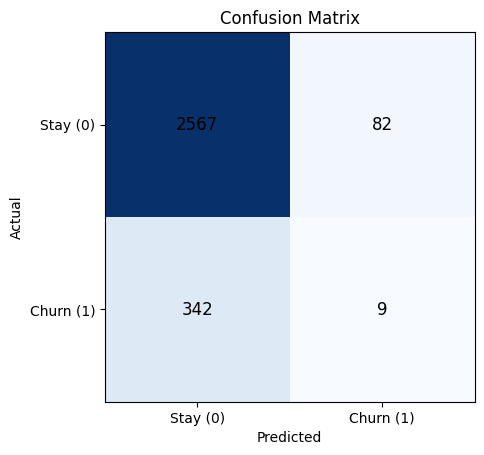

In [98]:
# Top-left (50) -> correctly predicted “Stay”
# Top-right (10) -> false alarms (predicted churn, actually stayed)
# Bottom-right (35) -> correctly predicted “Churn”
# Bottom-left (5) -> missed churns

# Plot nicely
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"]); ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [99]:
fi = pd.Series(best_clf.feature_importances_, index=X.columns) if 'best_clf' in globals() else pd.Series(clf.feature_importances_, index=X.columns)
print("Feature importance (higher = more influence):")
display(fi.sort_values(ascending=False).to_frame("importance"))



Feature importance (higher = more influence):


,importance
tenure_months,0.335162
age,0.259986
complaints,0.252451
usage_gb,0.152402
plan_type_enc,0.000000


In [100]:
import joblib

In [101]:
model_to_save = best_clf if 'best_clf' in globals() else clf
joblib.dump(model_to_save, "churn_decision_tree.joblib")
print("Saved churn_decision_tree.joblib")


Saved churn_decision_tree.joblib


In [102]:
# Example: predict churn for a new customer
new_customer = pd.DataFrame([{
    "age": 28, "usage_gb": 6.0, "complaints": 3, "tenure_months": 4, "plan_type_enc": 0  # Prepaid
}])


In [103]:
print("Predicted churn (1=churn):", int(model_to_save.predict(new_customer)[0]))

Predicted churn (1=churn): 0
